### Importing Necessary Modules

In [4]:
#import libraries
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import json
import os 
import pickle
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.layers import Dense , Input , LSTM ,Dropout ,Bidirectional, Embedding , add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from keras import metrics 
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

### **Image Processing and Feature Extraction:**

In [5]:
model = InceptionV3(include_top=True,weights='imagenet')

model = Model(inputs = model.inputs, outputs= model.layers[-2].output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [6]:
#read data
path ="../input/flickr8k/Images/"
feature = {}

for imag in tqdm(os.listdir(path)):
    image_path = path + imag
    image = load_img(image_path,target_size=(299,299))
    image= img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image= tf.keras.applications.inception_v3.preprocess_input(image)
    
    features = model.predict(image,verbose=0)
    image_id = imag.split(".")[0]
    
    feature[image_id] = features

  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
#store features in pkl file
pickle.dump(features,open('features.pkl','wb'))

In [8]:
with open('./features.pkl', 'rb') as f:
    features = pickle.load(f)

### **Text Preprocesing:**

In [9]:
#load catpions
with open('../input/flickr8k/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
#captions_doc

In [11]:
mapping={}

for line in tqdm(captions_doc.split("\n")):
    token = line.split(",")
    if len(token)<2 :
        continue
        
    image_id = token[0].split(".")[0]
    caption = token[1:]
    caption = "".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

['A young girl has on rollerblades and looks ready to give it a try .',
 'A young girl on Rollerblades .',
 'A young girl with rollerblades and green foliage in the background .',
 'The girl is wearing a blue striped shirt and Rollerblades .',
 'The young girl is rollerblading outside near green bushes .']

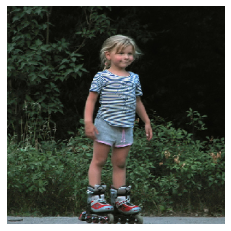

In [13]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(299,299))
    img = img_to_array(img)
    img = img/255.
    
    return img
image = readImage('/kaggle/input/flickr8k/Images/745966757_6d16dfad8f.jpg')
plt.imshow(image)
plt.axis('off');
mapping['745966757_6d16dfad8f']

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'SOS ' + " ".join([word for word in caption.split() if len(word)>1]) + ' EOS'
            captions[i] = caption

In [15]:
clean(mapping)

In [16]:
len(mapping)

8091

In [17]:
mapping["1000268201_693b08cb0e"]

['SOS child in pink dress is climbing up set of stairs in an entry way EOS',
 'SOS girl going into wooden building EOS',
 'SOS little girl climbing into wooden playhouse EOS',
 'SOS little girl climbing the stairs to her playhouse EOS',
 'SOS little girl in pink dress going into wooden cabin EOS']

In [18]:
total_caption = []
for key in mapping:
    for value in mapping[key]:
        total_caption.append(value)

In [19]:
len(total_caption)

40455

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_caption)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
total_caption[:5]

['SOS child in pink dress is climbing up set of stairs in an entry way EOS',
 'SOS girl going into wooden building EOS',
 'SOS little girl climbing into wooden playhouse EOS',
 'SOS little girl climbing the stairs to her playhouse EOS',
 'SOS little girl in pink dress going into wooden cabin EOS']

In [23]:
max_length = max(len(caption.split()) for caption in total_caption)
max_length

35

In [24]:
#Splitting into training and testing data images.

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [25]:
len(test)

810

In [26]:
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images
    X1,X2,y = list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                seq= tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq , out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
                    out_seq= to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    X1.append(feature[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2], y 
                X1,X2,y = list(),list(),list()
                n=0

### **Model Building**

In [31]:
#ENCODER

#image features layer
inputs1 = Input(shape=(2048,))
fe0 = Dense(512, activation='relu')(inputs1)
fe1 = Dropout(0.4)(fe0)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
#max lenght is maxmuim caption size of our dataset 
inputs2 = Input(shape=(35,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.1)(se1)
se3 = LSTM(256)(se2)
# se4 = Dropout(0.3)(se3)
# se5 = LSTM(256)(se4)

#decoder 
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(128, activation='relu')(decoder2)
outputs = Dense(vocab_size,activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Nadam',metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          1049088     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 256)      2172160     input_12[0][0]                   
____________________________________________________________________________________________

In [32]:
batch_size = 32 
epochs = 40
max_length = 35 
steps = len(train)//batch_size
for epoch in range(epochs) :
    generator = data_generator(train, mapping, feature, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=2, steps_per_epoch=steps, verbose=1)

Epoch 1/2
227/227 [==============================] - 69s 286ms/step - loss: 5.3389 - accuracy: 0.1517
Epoch 2/2
227/227 [==============================] - 68s 300ms/step - loss: 4.2565 - accuracy: 0.2381
Epoch 1/2
227/227 [==============================] - 64s 282ms/step - loss: 3.8713 - accuracy: 0.2705
Epoch 2/2
227/227 [==============================] - 65s 285ms/step - loss: 3.6300 - accuracy: 0.2905
Epoch 1/2
227/227 [==============================] - 62s 271ms/step - loss: 3.4580 - accuracy: 0.3049
Epoch 2/2
227/227 [==============================] - 62s 274ms/step - loss: 3.3104 - accuracy: 0.3176
Epoch 1/2
227/227 [==============================] - 62s 273ms/step - loss: 3.1881 - accuracy: 0.3280
Epoch 2/2
227/227 [==============================] - 61s 269ms/step - loss: 3.0819 - accuracy: 0.3368
Epoch 1/2
227/227 [==============================] - 62s 275ms/step - loss: 2.9896 - accuracy: 0.3465
Epoch 2/2
227/227 [==============================] - 62s 275ms/step - loss: 2.9060

In [33]:
model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'SOS'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'EOS':
            break
      
    return in_text

### Metrics - BLEU Score

In [36]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, feature[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.158162
BLEU-2: 0.088755


### Text-To-Speech 

In [38]:
!pip install gtts
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=feae46a01470c0cc2bc20de90df35748b492a65c56c7e32e35fecd6317cb055b
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [39]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display

#we will use the google text to speech api to convert the predicted text caption to speech

In [170]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("../input/flickr8k", "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------\n')
    for caption in captions:
            n =  len(caption)
            caption =  caption [:n-3]
            print(caption[3:])
    # predict the caption
    y_pred = predict_caption(model, feature[image_id], tokenizer, max_length)
    print('\n--------------------Predicted--------------------\n')
    n =  len(y_pred)
    y_pred =  y_pred [:n-77]
    y_pred = y_pred[3:]
    print(y_pred)
    plt.imshow(image)
    
    print("\n\n")
    print("----------------Predicted Audio Caption-------------\n")
    
    speech = gTTS('Predicted Caption : ' + y_pred, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = False))
    
    print("\n")
    print("---------------------The image---------------------\n")
    


### ***PREDICTIONS***

eos refers to 'end of sentence' tag used to refer the end tag of a sentence (used in padding). It doesnt add any meaning to the setence.

---------------------Actual---------------------

 kayaker wearing blue wetsuit and black helmet paddles his yellow kayak in murky rolling rapids 
 man kayaking through rapids 
 man wearing life jacket and helmet is water rafting down river 
 "a person in blue shirt helmet and life jacket paddles yellow kayak ." 
 person white-water rafting in turbulent water 

--------------------Predicted--------------------

 kayaker in yellow kayak paddles through the water eos eos eos eos eos eos eos eo



----------------Predicted Audio Caption-------------





---------------------The image---------------------



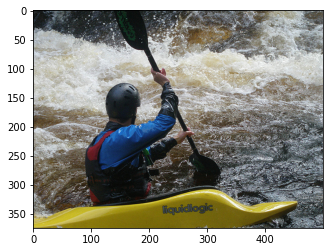

In [171]:
generate_caption("1473080948_bae2925dc8.jpg")

---------------------Actual---------------------

 boy in blue carries bucket 
 boy in blue swim trunks carries blue bucket down crowded beach 
 child walks on the beach with bucket 
 the boy in the blue shorts is carrying bucket on the beach 
 young boy in blue shorts at the beach 

--------------------Predicted--------------------

 boy in blue shorts is playing with brown dog on the beach eos eos eos eos eos e



----------------Predicted Audio Caption-------------





---------------------The image---------------------



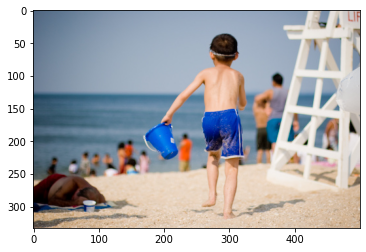

In [188]:
generate_caption("823675317_b5fbdb17b3.jpg")

---------------------Actual---------------------

 group of young boys on opposing teams are playing soccer 
 children playing soccer near the goal net 
 four boys playing soccer 
 four children run along grassy field playing soccer 
 the young boy in the red shirt is kicking soccer ball 

--------------------Predicted--------------------

 two boys play soccer while two boys are playing in the air eos eos eos eos eos eos 



----------------Predicted Audio Caption-------------





---------------------The image---------------------



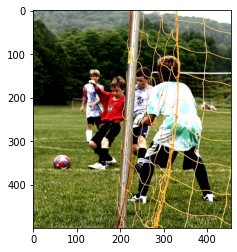

In [172]:
generate_caption("3724150944_fc62e8d5e0.jpg")

---------------------Actual---------------------

 lone hiker treks through deep snow near rocky peaks 
 mountain climber on snowy plain near mountaintop 
 person travels down snowy path into the mountains 
 "on mountaintop climber is seen in the distance black figure against white snow" 
 someone is walking through the snow with snow covered mountains behind them 

--------------------Predicted--------------------

 person travels down snowy hill to another person to look at mountains in the background eos 



----------------Predicted Audio Caption-------------





---------------------The image---------------------



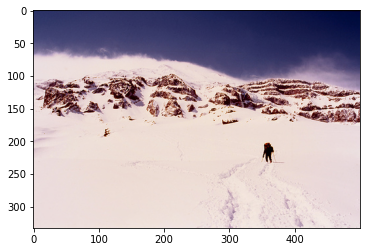

In [174]:
generate_caption("336551609_1385ab139e.jpg")

---------------------Actual---------------------

 horse leaps over fence while rider hangs on 
 man riding horse jumping over wooden fence 
 person in yellow helmet is jumping brown horse over fence 
 the horse and rider are jumping over fence 
 the horse and rider jump fence 

--------------------Predicted--------------------

 horse leaps over fence eos eos eos eos eos eos eos eos eos eos eos eos eos



----------------Predicted Audio Caption-------------





---------------------The image---------------------



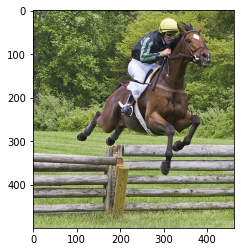

In [175]:
generate_caption("3541962817_78bcd3835b.jpg")

---------------------Actual---------------------

 white ad brown dog is running on grass 
 white dog wearing red collar is jumping up from the grass 
 white dog with patches of brown and black on his eye is running through green grass 
 the small white dog jumps in the grass 
 white and brown dog with mouth open running on grass 

--------------------Predicted--------------------

 small white dog is running on the grass eos eos eos eos up eos eos e



----------------Predicted Audio Caption-------------





---------------------The image---------------------



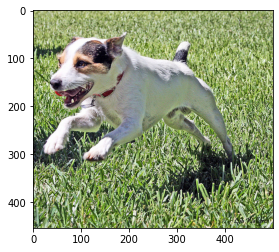

In [178]:
generate_caption("2994104606_bc2df6c1f4.jpg")

EOP